# **로지스틱 회귀 (Logistic Regression)**

* 로지스틱 회귀는 분류(Classification) 문제를 해결하기 위해 널리 사용되는 알고리즘 중 하나로, 이름에 '회귀'라는 단어가 포함되어 있지만, 실제로는 이진 분류(Binary Classification) 문제에 주로 사용
* 로지스틱 회귀는 선형 회귀 모델의 출력에 시그모이드(Sigmoid) 함수를 적용하여, 예측 값을 0과 1 사이의 확률로 변환

### 시그모이드 함수와 예측 함수

\begin{equation}
\sigma(x) = \frac{1}{1 + e^{-x}}
\end{equation}

\begin{equation}
\hat{y} = \sigma(w_0 + w_1 x_1 + ... + w_p x_p)
\end{equation}

* $\sigma$는 시그모이드 함수이고, $w_0, w_1, ..., w_p$는 모델의 파라미터에 해당

### 목적 함수

* 로지스틱 회귀의 학습 목표는 아래의 바이너리 크로스 엔트로피 손실(Binary Cross Entropy Loss)을 최소화하는 파라미터 $w$를 찾는 것

\begin{equation}
BinaryCrossEntropy = -\frac{1}{N}\sum_{i=1}^{N}y_i\log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)
\end{equation}

***

### SECOM 데이터셋
* **데이터셋**: SECOM (SEmiCOnductor Manufacturing) 반도체 제조 공정 다변량 시계열 노이즈 데이터
* **설명**: 반도체 칩 생산 과정 중 여러 센서가 수집한 값을 기록한 데이터로, 각 센서는 온도, 압력, 진동 등 다양한 공정 변수를 의미
* **문제**: 제조 공정에서 불량품 예측 (Pass/Fail 이진 분류)
* **샘플 수**: 1,567개
* **특성 수**: 590개 (센서 측정값)
* **클래스 불균형**: Pass 93.4% vs Fail 6.6%
* **결측치**: 매우 많음

### 실습 목표
1. 실제 제조 데이터의 특성 이해
2. 고차원 데이터 전처리 파이프라인 구축
3. 클래스 불균형 문제 해결
4. Logistic Regression의 Feature Importance 분석

## 1. 라이브러리 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve
)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

In [ ]:
# Logistic Regression 기본 작동을 확인하기 위한 임의의 데이터 생성

# 샘플 수 정의
samples = 1000

# make_classification을 사용해 샘플 데이터 생성
# n_samples: 생성할 샘플 수
# n_features: 특성(피처)의 수
# n_informative: 유의미한(유용한) 특성 수
# n_redundant: 중복되는 특성 수
# n_clusters_per_class: 클래스 당 클러스터 수
X, y = make_classification(n_samples=samples, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

In [ ]:
# Logistic Regression을 위한 생성된 데이터 시각화

# 하나의 서브플롯(fig와 ax 객체) 생성, 크기 설정
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# 그리드 추가
ax.grid()

# x축과 y축 레이블 설정
ax.set_xlabel('X')
ax.set_ylabel('y')

# 각 데이터 포인트를 반복하면서 시각화
# y 값이 0일 때 빨간색 삼각형으로, 1일 때 파란색 삼각형으로 표시
for i in range(samples):
    if y[i] == 0:
        ax.scatter(X[i, 0], X[i, 1], edgecolors='k', alpha=0.5, marker='^', color='r')  # 클래스 0 데이터 포인트
    else:
        ax.scatter(X[i, 0], X[i, 1], edgecolors='k', alpha=0.5, marker='^', color='b')  # 클래스 1 데이터 포인트

# 플롯 표시
plt.show()

In [ ]:
# 데이터를 훈련 세트와 테스트 세트로 분할

# train_test_split 함수를 사용해 데이터를 분할
# X: 입력 특성 데이터
# y: 타깃 레이블
# test_size=0.2: 테스트 세트의 비율을 20%로 설정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Logistic Regression 모델 학습 및 평가

# Logistic Regression 모델 초기화
model = LogisticRegression()

# 훈련 데이터를 사용하여 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터에 대한 모델 성능 출력
print('평가 데이터 점수: {}'.format(model.score(X_test, y_test)))

In [ ]:
# 교차 검증을 통한 Logistic Regression 모델 성능 평가

# cross_val_score 함수를 사용해 10-fold 교차 검증 수행
# model: 평가할 모델
# X: 전체 입력 특성 데이터
# y: 전체 타깃 레이블
# scoring='accuracy': 모델의 정확도를 평가 척도로 사용
# cv=10: 10개의 폴드(folds)를 사용하여 교차 검증 수행
scores = cross_val_score(model, X, y, scoring='accuracy', cv=10)

# 교차 검증 결과의 평균 점수 출력
print('CV 평균 점수: {}'.format(scores.mean()))

In [ ]:
# Logistic Regression 모델의 결정 경계 시각화

# x와 y 특성의 최소/최대 값 설정 (결정 경계 시각화를 위해 여유 공간 0.5 추가)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# x와 y 값에 대해 그리드 생성 (결정 경계 그리드를 만들기 위한 좌표)
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# 그리드 좌표로 예측 수행 (각 그리드 점에서의 클래스 예측)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# 예측 결과를 그리드 모양에 맞게 재구성
Z = Z.reshape(xx.shape)

# 결정 경계 시각화
plt.figure(1, figsize=(10, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel1)  # 결정 경계를 컬러로 표현

# 실제 데이터 포인트를 산점도로 시각화
plt.scatter(X[:, 0], X[:, 1], c=np.abs(y - 1), edgecolors='k', alpha=0.5, marker='^', cmap=plt.cm.coolwarm)

# x축과 y축 레이블 설정
plt.xlabel('X')
plt.ylabel('y')

# x축과 y축의 범위 설정
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# x축과 y축의 눈금 설정
plt.xticks()
plt.yticks()

# 플롯 표시
plt.show()

## 2. 데이터 로딩 및 탐색

In [2]:
# SECOM 데이터 로딩
X = pd.read_csv('../data/secom.data', sep='\s+', header=None)
y_data = pd.read_csv('../data/secom_labels.data', sep='\s+', header=None, 
                     names=['label', 'timestamp'])
y = y_data['label'].values

print(f"데이터 형태: {X.shape}")
print(f"라벨 형태: {y.shape}")
print(f"특성(Feature) 수: {X.shape[1]}")
print(f"샘플(Sample) 수: {X.shape[0]}")

데이터 형태: (1567, 590)
라벨 형태: (1567,)
특성(Feature) 수: 590
샘플(Sample) 수: 1567


=== 클래스 분포 ===
Pass (-1): 1463 (93.36%)
Fail (1):  104 (6.64%)


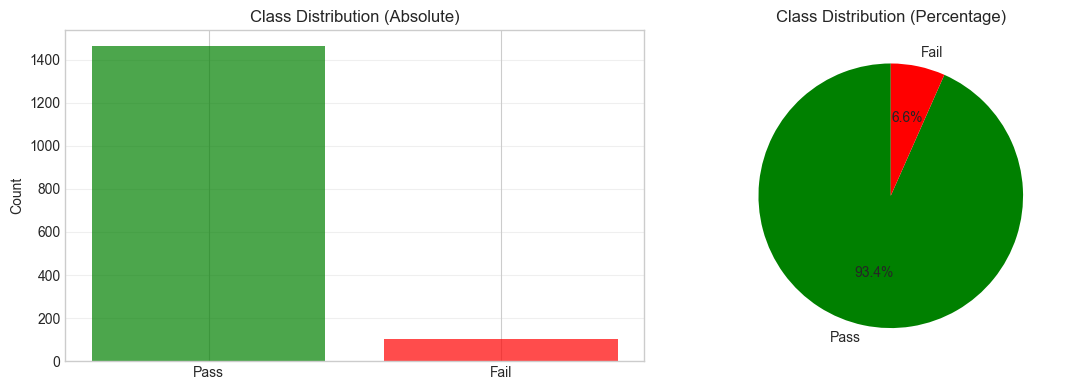

In [3]:
# 라벨 분포 확인
unique, counts = np.unique(y, return_counts=True)
label_dist = dict(zip(unique, counts))

print("=== 클래스 분포 ===")
print(f"Pass (-1): {label_dist[-1]} ({label_dist[-1]/len(y)*100:.2f}%)")
print(f"Fail (1):  {label_dist[1]} ({label_dist[1]/len(y)*100:.2f}%)")

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].bar(['Pass', 'Fail'], [label_dist[-1], label_dist[1]], color=['green', 'red'], alpha=0.7)
ax[0].set_ylabel('Count')
ax[0].set_title('Class Distribution (Absolute)')
ax[0].grid(axis='y', alpha=0.3)

ax[1].pie([label_dist[-1], label_dist[1]], labels=['Pass', 'Fail'], 
          autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
ax[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

## 3. 결측치 분석

실제 센서 데이터는 결측치가 많기 때문에, 결측치 패턴을 분석하고 처리 전략 필요

=== 결측치 분석 ===
총 특성 수: 590
결측치 없는 특성: 52개
결측치 <5% 특성: 538개
결측치 >50% 특성: 28개
결측치 >80% 특성: 8개


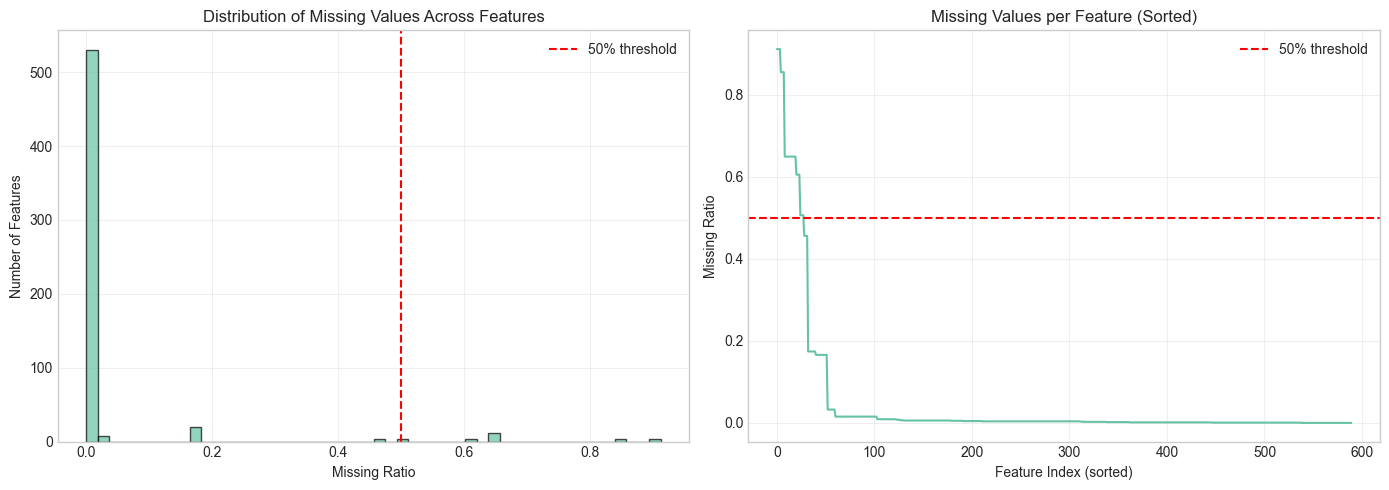

In [6]:
# 결측치 분석
missing_per_feature = X.isnull().sum()
missing_ratio = missing_per_feature / len(X)

print("=== 결측치 분석 ===")
print(f"총 특성 수: {X.shape[1]}")
print(f"결측치 없는 특성: {(missing_ratio == 0).sum()}개")
print(f"결측치 <5% 특성: {(missing_ratio < 0.05).sum()}개")
print(f"결측치 >50% 특성: {(missing_ratio > 0.5).sum()}개")
print(f"결측치 >80% 특성: {(missing_ratio > 0.8).sum()}개")

# 결측치 분포 시각화
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(missing_ratio, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Missing Ratio')
plt.ylabel('Number of Features')
plt.title('Distribution of Missing Values Across Features')
plt.axvline(x=0.5, color='r', linestyle='--', label='50% threshold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sorted_missing = missing_ratio.sort_values(ascending=False)
plt.plot(range(len(sorted_missing)), sorted_missing.values)
plt.xlabel('Feature Index (sorted)')
plt.ylabel('Missing Ratio')
plt.title('Missing Values per Feature (Sorted)')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% threshold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 데이터 전처리

### 전처리 전략:
1. **Feature Selection**: 결측치가 50% 이상인 feature 제거
2. **Imputation**: 남은 결측치는 평균값으로 대체
3. **Scaling**: StandardScaler로 표준화

In [7]:
# Step 1: 결측치 50% 이상인 feature 제거
missing_threshold = 0.5
valid_features = missing_ratio < missing_threshold
X_filtered = X.loc[:, valid_features]

print(f"=== Feature Selection ===")
print(f"원본 특성 수: {X.shape[1]}")
print(f"필터링 후 특성 수: {X_filtered.shape[1]}")
print(f"제거된 특성 수: {X.shape[1] - X_filtered.shape[1]}")

=== Feature Selection ===
원본 특성 수: 590
필터링 후 특성 수: 562
제거된 특성 수: 28


In [9]:
# Step 2: 결측치 Imputation (평균값 대체)
imputer = SimpleImputer(strategy='mean') # median(중앙값), most_frequent(최빈값)
X_imputed = imputer.fit_transform(X_filtered)

print(f"=== Imputation Complete ===")
print(f"Imputed 데이터 형태: {X_imputed.shape}")
print(f"남은 결측치: {np.isnan(X_imputed).sum()}")

=== Imputation Complete ===
Imputed 데이터 형태: (1567, 562)
남은 결측치: 0


In [10]:
# Step 3: Scaling (표준화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"=== Scaling Complete ===")
print(f"Scaled 데이터 형태: {X_scaled.shape}")
print(f"평균: {X_scaled.mean(axis=0).mean():.6f}") # 0에 가까워야 함
print(f"표준편차: {X_scaled.std(axis=0).mean():.6f}") # 1에 가까워야 함

=== Scaling Complete ===
Scaled 데이터 형태: (1567, 562)
평균: -0.000000
표준편차: 0.793594


## 5. Train/Test Split

In [11]:
# Stratified split (클래스 비율 유지): stratify 옵션을 y로 표기해 클래스 비율을 유지한 상태로 train / test split 이 진행되도록 실행
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"=== Train/Test Split ===")
print(f"Train 샘플 수: {len(X_train)}")
print(f"Test 샘플 수: {len(X_test)}")
print(f"Train Fail rate: {(y_train == 1).sum() / len(y_train) * 100:.2f}%")
print(f"Test Fail rate: {(y_test == 1).sum() / len(y_test) * 100:.2f}%")

=== Train/Test Split ===
Train 샘플 수: 1253
Test 샘플 수: 314
Train Fail rate: 6.62%
Test Fail rate: 6.69%


## 6. 모델 학습 (Baseline)

### 클래스 불균형 처리
- `class_weight='balanced'` 사용: 소수 클래스(Fail)에 더 높은 가중치 부여

In [18]:
# Baseline 모델 (class_weight 미사용)
model_baseline = LogisticRegression(max_iter=3000, random_state=42)
model_baseline.fit(X_train, y_train)

y_pred_baseline = model_baseline.predict(X_test)

print("=== Baseline Model (No class_weight) ===")
print(f"Accuracy: {model_baseline.score(X_test, y_test):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_baseline, pos_label=1):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline, pos_label=1, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline, pos_label=1):.4f}")
print(f"Accuracy가 높아도 F1-score가 낮으면 불균형 문제!")

=== Baseline Model (No class_weight) ===
Accuracy: 0.8790
F1-score: 0.1364
Precision: 0.1304
Recall: 0.1429
Accuracy가 높아도 F1-score가 낮으면 불균형 문제!


In [20]:
# Balanced 모델 (class_weight='balanced')
model_balanced = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=42)
model_balanced.fit(X_train, y_train)

y_pred_balanced = model_balanced.predict(X_test)

print("=== Balanced Model (class_weight='balanced') ===")
print(f"Accuracy: {model_balanced.score(X_test, y_test):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_balanced, pos_label=1):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_balanced, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_balanced, pos_label=1):.4f}")
print(f"클래스 불균형이 극도로 강해 False Positive 증가로 인한 Precision 및 F1 감소")

=== Balanced Model (class_weight='balanced') ===
Accuracy: 0.8376
F1-score: 0.1356
Precision: 0.1053
Recall: 0.1905
클래스 불균형이 극도로 강해 False Positive 증가로 인한 Precision 및 F1 감소


## 7. 모델 평가

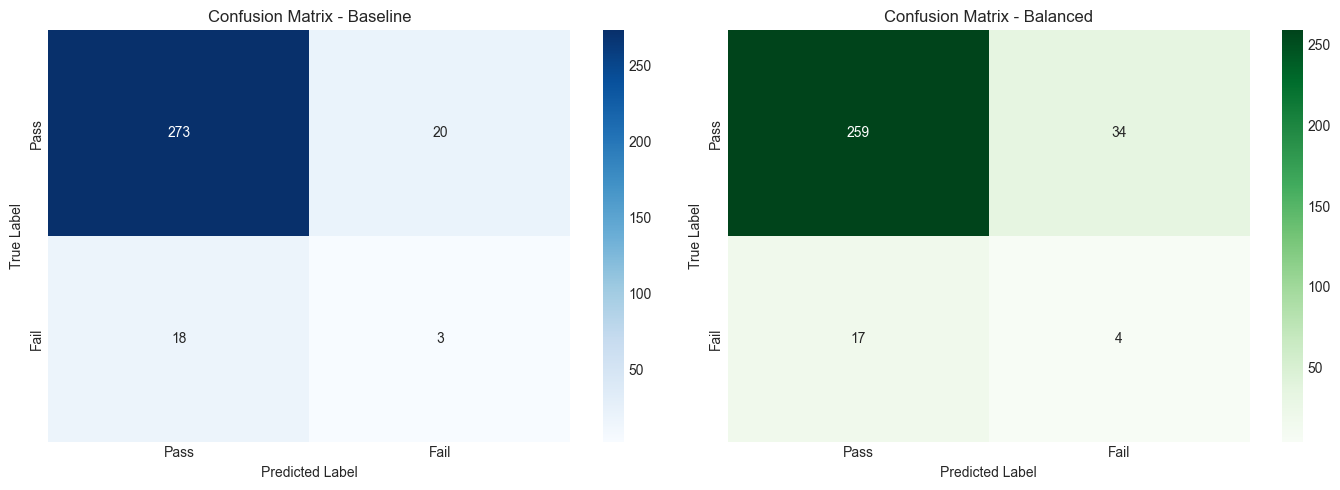

Tip: Balanced 모델이 소수 클래스에 해당하는 불량(1)에 더 민감하게 탐지


In [22]:
# Confusion Matrix 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'])
axes[0].set_title('Confusion Matrix - Baseline')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Balanced
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'])
axes[1].set_title('Confusion Matrix - Balanced')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("Tip: Balanced 모델이 소수 클래스에 해당하는 불량(1)에 더 민감하게 탐지")

In [23]:
# Classification Report
print("=== Classification Report - Balanced Model ===")
print(classification_report(y_test, y_pred_balanced, target_names=['Pass', 'Fail']))

=== Classification Report - Balanced Model ===
              precision    recall  f1-score   support

        Pass       0.94      0.88      0.91       293
        Fail       0.11      0.19      0.14        21

    accuracy                           0.84       314
   macro avg       0.52      0.54      0.52       314
weighted avg       0.88      0.84      0.86       314



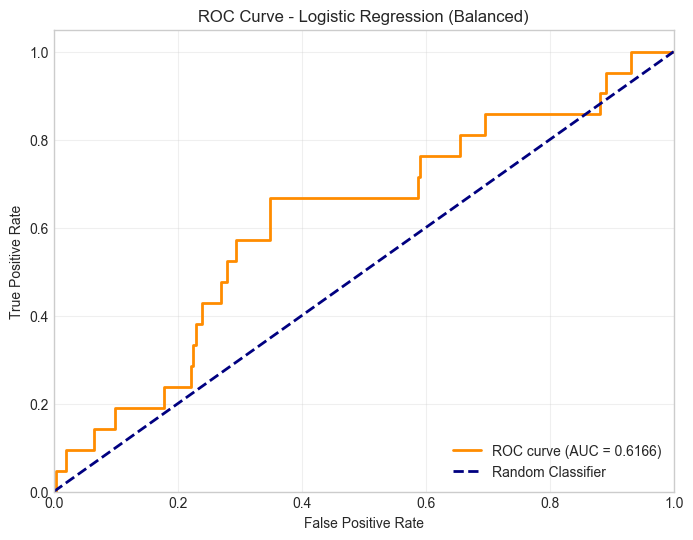

ROC-AUC Score: 0.6166


In [24]:
# ROC Curve
y_pred_proba = model_balanced.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Balanced)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

## 8. Feature Importance 분석

Logistic Regression의 계수(coefficient)를 통해 어떤 센서가 불량 예측에 중요한지 확인합니다.

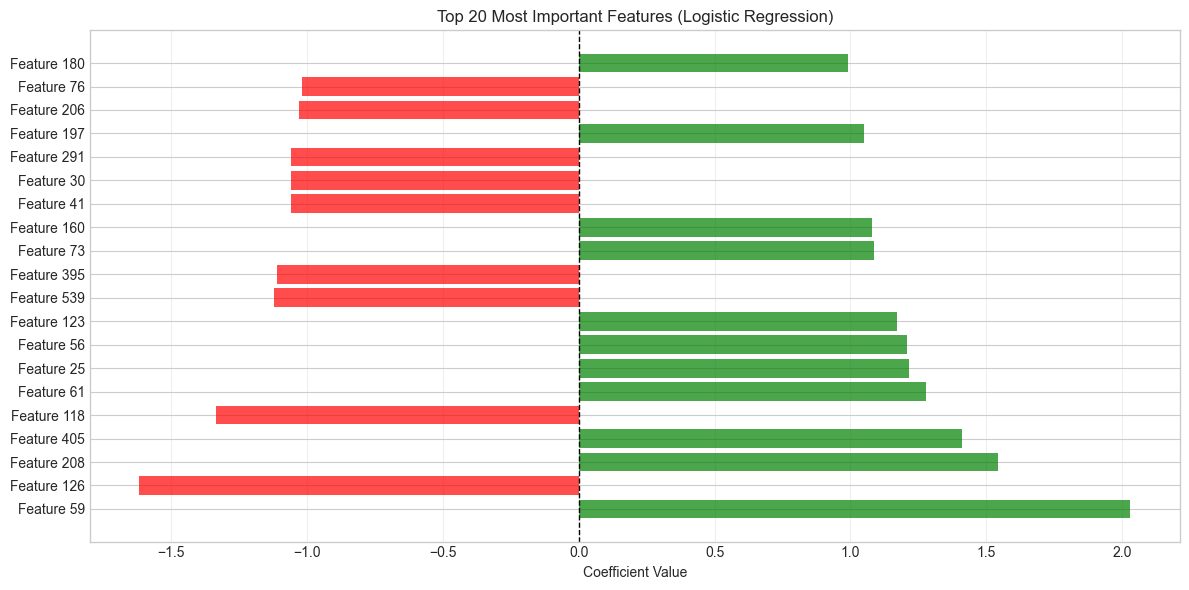

=== Top 10 Most Important Features ===
     feature_idx  coefficient  abs_coefficient
59            59     2.030360         2.030360
126          126    -1.616144         1.616144
208          208     1.541239         1.541239
405          405     1.409553         1.409553
118          118    -1.335402         1.335402
61            61     1.278180         1.278180
25            25     1.213949         1.213949
56            56     1.209356         1.209356
123          123     1.171725         1.171725
539          539    -1.120071         1.120071

💡 양수 계수: Fail 가능성 증가
💡 음수 계수: Pass 가능성 증가


In [25]:
# Feature Importance (계수의 절댓값)
coefficients = model_balanced.coef_[0]
feature_importance = pd.DataFrame({
    'feature_idx': range(len(coefficients)),
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# Top 20 중요 특성
top_features = feature_importance.nlargest(20, 'abs_coefficient')

plt.figure(figsize=(12, 6))
colors = ['red' if c < 0 else 'green' for c in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), [f"Feature {idx}" for idx in top_features['feature_idx']])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Most Important Features (Logistic Regression)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("=== Top 10 Most Important Features ===")
print(top_features.head(10)[['feature_idx', 'coefficient', 'abs_coefficient']])
print("\n💡 양수 계수: Fail 가능성 증가")
print("💡 음수 계수: Pass 가능성 증가")

## 9. 하이퍼파라미터 튜닝 (GridSearchCV)

In [26]:
# GridSearchCV로 최적 C 값 탐색
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=3000, class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # F1-score 최적화
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV 실행 중...")
grid_search.fit(X_train, y_train)

print(f"\n=== GridSearchCV Results ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

GridSearchCV 실행 중...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

=== GridSearchCV Results ===
Best Parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1-score: 0.2408


In [27]:
# 최적 모델로 평가
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("=== Best Model Performance ===")
print(f"Test Accuracy: {best_model.score(X_test, y_test):.4f}")
print(f"Test F1-score: {f1_score(y_test, y_pred_best, pos_label=1):.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred_best, pos_label=1):.4f}")
print(f"Test Recall: {recall_score(y_test, y_pred_best, pos_label=1):.4f}")

print("\n=== Confusion Matrix ===")
cm_best = confusion_matrix(y_test, y_pred_best)
print(cm_best)

=== Best Model Performance ===
Test Accuracy: 0.8121
Test F1-score: 0.1194
Test Precision: 0.0870
Test Recall: 0.1905

=== Confusion Matrix ===
[[251  42]
 [ 17   4]]


## 10. 결과 요약 및 해석

### 주요 발견사항:
1. **클래스 불균형 처리의 중요성**: `class_weight='balanced'` 사용 시 F1-score 향상
2. **전처리의 중요성**: 결측치 처리와 scaling이 필수
3. **평가 지표 선택**: Accuracy보다 F1-score, Precision, Recall이 중요
4. **Feature Selection**: 590개 중 중요한 센서만 선택하여 효율성 향상

### 실무 적용:
- 반도체 제조 라인에서 불량 예측 시스템 구축
- 중요 센서 식별로 모니터링 비용 절감
- Recall 중시: 불량품을 Pass로 잘못 판정하는 것을 최소화

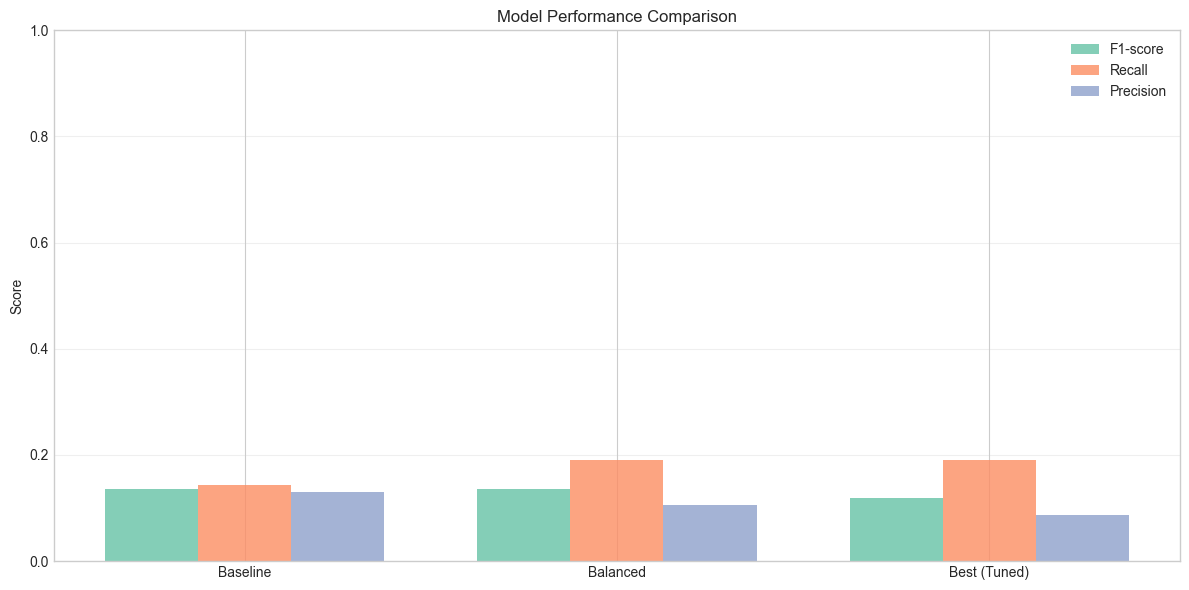

In [28]:
# 최종 성능 비교 시각화
models = ['Baseline', 'Balanced', 'Best (Tuned)']
f1_scores = [
    f1_score(y_test, y_pred_baseline, pos_label=1),
    f1_score(y_test, y_pred_balanced, pos_label=1),
    f1_score(y_test, y_pred_best, pos_label=1)
]
recalls = [
    recall_score(y_test, y_pred_baseline, pos_label=1),
    recall_score(y_test, y_pred_balanced, pos_label=1),
    recall_score(y_test, y_pred_best, pos_label=1)
]
precisions = [
    precision_score(y_test, y_pred_baseline, pos_label=1, zero_division=0),
    precision_score(y_test, y_pred_balanced, pos_label=1),
    precision_score(y_test, y_pred_best, pos_label=1)
]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, f1_scores, width, label='F1-score', alpha=0.8)
ax.bar(x, recalls, width, label='Recall', alpha=0.8)
ax.bar(x + width, precisions, width, label='Precision', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()